# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project 2: Build a Traffic Sign Recognition Classifier

---
## Step 0: Import Lib

In [1]:
import numpy as np
import pickle  # Load pickled data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import random
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

---
## Step 1: Load, Explore and Visualize DATA

In [2]:
# Laod data from file 
training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

try:
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
        print("Successfully load training data")
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
        print("Successfully load validation data")
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
        print("Successfully load test data")
    print("Successfully load all data")  
except : # parent of IOError, OSError *and* WindowsError where available
    print("Fail to load all data")

Successfully load training data
Successfully load validation data
Successfully load test data
Successfully load all data


In [13]:
# Split into features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Explore data 
image_shape = X_train[0].shape
n_classes = max(y_train) - min(y_train) + 1
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)

print("Image data shape:    {}".format(image_shape))
print("Number of classes:   {}".format(n_classes))
print()
print("Number of training examples:   {}".format(n_train))
print("Number of validation examples: {}".format(n_valid))
print("Number of testing examples:    {}".format(n_test))

Image data shape:    (32, 32, 3)
Number of classes:   43

Number of training examples:   34799
Number of validation examples: 4410
Number of testing examples:    12630


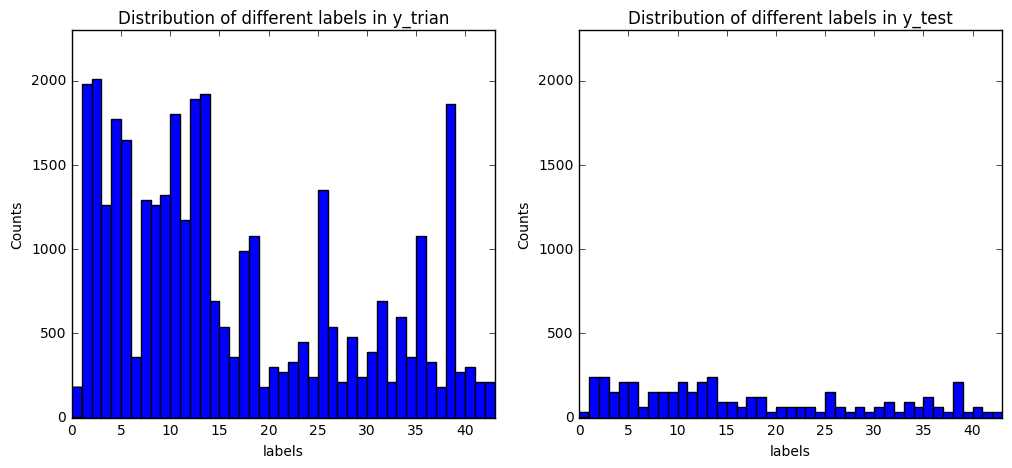

Below are images that randomly selected in database, each row belogs to same class, different rows belongs to differnt class


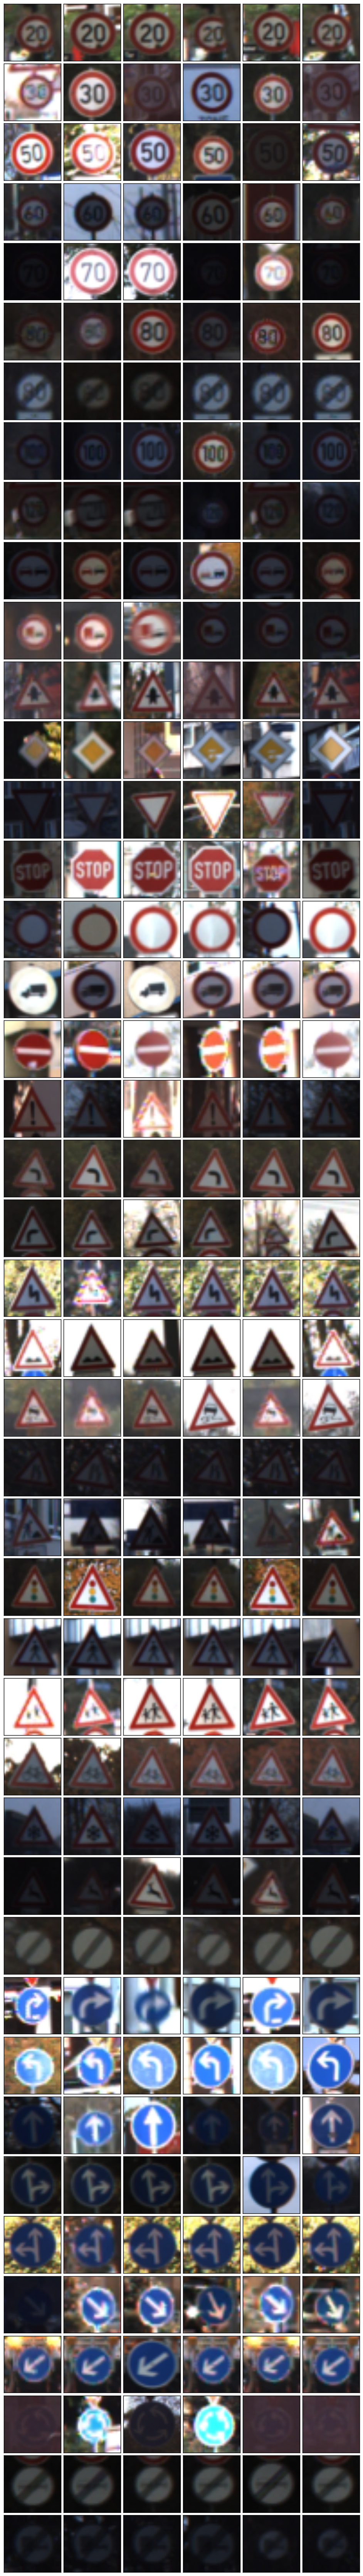

In [4]:
# Visualization of the dataset
# First visualize the label distribution in training and test data
fig = plt.figure(figsize=(12, 5))
train_label_dist = fig.add_subplot(121)
test_label_dist = fig.add_subplot(122)

train_label_dist.hist(y_train,bins=43,range=(0,43),align='mid',histtype="barstacked")
train_label_dist.axis([0, 43, 0, 2300])
train_label_dist.set_title("Distribution of different labels in y_trian")
train_label_dist.set_xlabel("labels")
train_label_dist.set_ylabel("Counts")

test_label_dist.hist(y_valid,bins=43,range=(0,43),align='mid',histtype="barstacked")
test_label_dist.axis([0, 43, 0, 2300])
test_label_dist.set_title("Distribution of different labels in y_test")
test_label_dist.set_xlabel("labels")
test_label_dist.set_ylabel("Counts")

plt.show()

# Visualize random selected images with each label
print("Below are images that randomly selected in database, each row belogs to same class, "+
      "different rows belongs to differnt class")
# six images per class label     
sample_size = 6
gs = gridspec.GridSpec(n_classes, sample_size, wspace=0, hspace=0.05)
fig = plt.figure(figsize=(sample_size*2, n_classes*2))
for i in range(n_classes):
    ind = y_valid == i
    subset_x = X_valid[ind] # get all images that belong to class i from validation data thus speed up the process
    for j in range(sample_size):
        img = random.choice(subset_x) # randomly pick on image from class i
        ax = plt.Subplot(fig, gs[i*6+ j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        fig.add_subplot(ax)

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Pre-process the Data Set (normalization, grayscale, etc.)

In [5]:
# Data normalization 
X_train=X_train/255-0.5
X_valid=X_valid/255-0.5
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

### Model Architecture and parameter setting

In [6]:
def FengNet(x): 
    """
    Return logits of my neural network which combined with 3 layer of CNN and 3 layer of FN
    Input: Image with shape (32, 32, 3)
    """
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Use dropout layer to prevent overfitting 
    conv1   = tf.nn.dropout(conv1, keep_prob)

    # Layer 2: Convolutional. Output = 26x26x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    # Use Pooling: Input = 26x26x16. Output = 13x13x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2   = tf.nn.dropout(conv2, keep_prob)
    
    # Layer 3: Convolutional. Output = 9x9x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    conv3   = tf.nn.dropout(conv3, keep_prob)
    
    # Flatten. Input = 9x9x64. Output = 5184.
    fc0   = flatten(conv3)
    
    # Layer 4: Fully Connected. Input = 5184. Output = 1000.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(5184, 1000), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1000))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 5: Fully Connected. Input = 1000. Output = 200.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1000, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 200. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [8]:
# Set tensor for our network
EPOCHS = 10
BATCH_SIZE = 1000

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)
logits = FengNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer()
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    """
    Return the accuracy given X_data (featuren) and y_data (label)
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

In [9]:
with tf.Session() as sess:
    try:
        sess.run(tf.initialize_all_variables())
    except:
        sess.run(tf.global_variables_initializer())
        
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './fengnet')
    print("Model saved")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.252

EPOCH 2 ...
Validation Accuracy = 0.616

EPOCH 3 ...
Validation Accuracy = 0.818

EPOCH 4 ...
Validation Accuracy = 0.890

EPOCH 5 ...
Validation Accuracy = 0.926

EPOCH 6 ...
Validation Accuracy = 0.937

EPOCH 7 ...
Validation Accuracy = 0.939

EPOCH 8 ...
Validation Accuracy = 0.947

EPOCH 9 ...
Validation Accuracy = 0.950

EPOCH 10 ...
Validation Accuracy = 0.941

Model saved


In [10]:
# Continue training based on previous work if the accuracy is not good enough
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    optimizer = tf.train.AdamOptimizer()
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.9})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './fengnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.954

EPOCH 2 ...
Validation Accuracy = 0.954

EPOCH 3 ...
Validation Accuracy = 0.955

EPOCH 4 ...
Validation Accuracy = 0.954

EPOCH 5 ...
Validation Accuracy = 0.954

EPOCH 6 ...
Validation Accuracy = 0.954

EPOCH 7 ...
Validation Accuracy = 0.958

EPOCH 8 ...
Validation Accuracy = 0.954

EPOCH 9 ...
Validation Accuracy = 0.957

EPOCH 10 ...
Validation Accuracy = 0.951

Model saved


### Test the Model

In [14]:
# Data normalization 
X_test=X_test/255-0.5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))          
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print()

Test Accuracy = 0.933

